**Preparation**

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
import os.path as osp
import pickle
import cv2
plt.rcParams["font.family"] = "Times New Roman"

**Generate Loss Curve**

In [3]:
def vis_loss_curve(filename, data):
    plt.figure(figsize=(8, 6))

    def smooth_curve(scalars, weight):
        last = scalars[0]
        smoothed = list()
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    train_losses = np.transpose(data[:,[0,1]])
    plt.plot(train_losses[0], smooth_curve(train_losses[1], 0.95))

    val_losses = np.transpose(data[:,[0,2]])
    plt.plot(val_losses[0], smooth_curve(val_losses[1], 0.95))

    plt.legend(['Training', 'Validation'], loc='upper left')

    plt.savefig(filename, bbox_inches='tight')

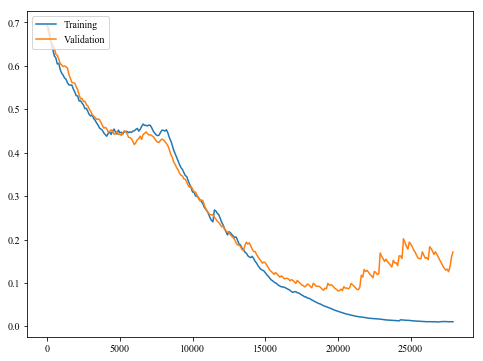

In [4]:
df = pd.read_csv('loss_curve.csv')
data = df.as_matrix()
vis_loss_curve('loss_curve.pdf', data)

**Get Success and Failure Examples**

In [5]:
train_dir = 'train_dir/kitti_long_bs_1_lr_0.002_20181126-131308'

In [6]:
test_logfile = osp.join(train_dir, 'test_result.p')
with open(test_logfile, 'rb') as f:
    res = pickle.load(f)

In [7]:
print(res.keys())

dict_keys(['pred', 'loss', 'tp', 'probs', 'pixel_level_iou', 'fp', 'fn'])


In [8]:
print('Testing Loss: {:3f}'.format(res['loss']))
print('Testing Pixel-level IOU: {:3f}'.format(res['pixel_level_iou']))

Testing Loss: 0.238040
Testing Pixel-level IOU: 0.850975


In [9]:
from data_util import load_datasets
_, _, dataset_test = load_datasets('data')

pred = np.squeeze(res['pred'])[:, :, :]
pred = np.stack((pred,)*3, axis=-1) * np.array([0., 0., 1.]) + np.array([1., 0., 0.])

images = dataset_test["image"]

In [10]:
gt_images = []
for image_id in dataset_test['id']:
    gt_filename = image_id.split('_')[0] + '_road_' + image_id.split('_')[1]
    img = cv2.imread(osp.join('data/gt/test/', gt_filename + '.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gt_images.append(img)
gt_images = np.stack(gt_images) * 255

In [11]:
for ix in range(gt_images.shape[0]):
    vis = np.concatenate((images[ix], pred[ix], gt_images[ix]), axis=0)
    
    # setup figure
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(vis)

    # configure axis ticks
    ax.set_yticks((np.arange(3) + 0.5) * gt_images.shape[1])
    ax.set_yticklabels(['Image', 'Prediction', 'Ground Truth'], fontsize=24, position=(-0.03, 0))
    ax.get_xaxis().set_visible(False)
    
    fname = osp.join('test_images', 'test_image_' + str(ix) + '.pdf')
    plt.savefig(fname, bbox_inches='tight')
    plt.close(fig)